In [78]:
import opendatasets as od
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
od.download('https://www.kaggle.com/enisahovi/cats-projekat-4')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dikshantkalotra
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:01<00:00, 195MB/s]


The dataset contains pictures of five different wild cats (cheetah, tigers, jaguars, panthers, and leopards).
Pictures are downloaded from Google Images.
Each folder (animal) contains around 500 pictures.
There are about 3000 pictures in total.

In [79]:
data_dir = './cats-projekat-4'
print(os.listdir(data_dir))
print(os.listdir(data_dir + '/cats_projekat'))

['cats_projekat']
['tigers', 'panthers', 'leopards', 'jaguars', 'cheetahs']


In [80]:
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [81]:
tfms = tt.Compose([tt.Resize(image_size),
                   tt.CenterCrop(image_size),
                   tt.ToTensor(),
                   tt.Normalize(*stats)])

In [82]:
dataset = ImageFolder(data_dir+'/cats_projekat', transform=tfms)
dataset

Dataset ImageFolder
    Number of datapoints: 3080
    Root location: ./cats-projekat-4/cats_projekat
    StandardTransform
Transform: Compose(
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [83]:
print(dataset.classes, len(dataset))

['cheetahs', 'jaguars', 'leopards', 'panthers', 'tigers'] 3080


In [84]:
val_size = len(dataset) // 8
train_size = len(dataset) - val_size

val_size, train_size

(385, 2695)

In [85]:
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
train_ds, valid_ds

(<torch.utils.data.dataset.Subset at 0x7f11a2f0ccd0>,
 <torch.utils.data.dataset.Subset at 0x7f11a2f0cc90>)

In [86]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory = True)
valid_dl = DataLoader(train_ds, batch_size*2, num_workers=2, pin_memory = True)

In [87]:
def denorm(img_tens):
  return img_tens * stats[1][0] + stats[0][0]

In [88]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

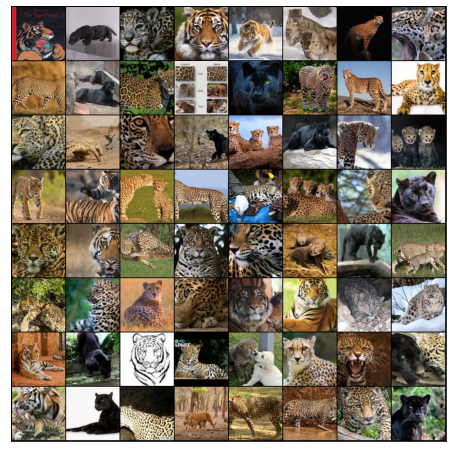

In [89]:
show_batch(train_dl)

In [90]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [91]:
device = get_default_device()
device


device(type='cuda')

In [92]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [93]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [94]:
model = models.resnet34()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [95]:
class WildResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [98]:
model = to_device(WildResnet(), device)
model

WildResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [99]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [100]:
model.freeze()


In [101]:
epochs = 5
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [102]:
history = []

In [103]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00075, train_loss: 1.2644, val_loss: 1.0832, val_acc: 0.7859
Epoch [1], last_lr: 0.00095, train_loss: 1.0963, val_loss: 1.1409, val_acc: 0.7268
Epoch [2], last_lr: 0.00061, train_loss: 1.0614, val_loss: 1.2175, val_acc: 0.6386
Epoch [3], last_lr: 0.00019, train_loss: 1.0713, val_loss: 1.0347, val_acc: 0.8392
Epoch [4], last_lr: 0.00000, train_loss: 1.0227, val_loss: 1.0096, val_acc: 0.8745
CPU times: user 60 s, sys: 39.6 s, total: 1min 39s
Wall time: 3min 47s


In [104]:
model.unfreeze()

In [105]:
%%time
history += fit_one_cycle(epochs, 0.0001, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.00007, train_loss: 1.0224, val_loss: 0.9974, val_acc: 0.8926
Epoch [1], last_lr: 0.00010, train_loss: 1.0143, val_loss: 0.9904, val_acc: 0.8958
Epoch [2], last_lr: 0.00006, train_loss: 0.9950, val_loss: 0.9789, val_acc: 0.9109
Epoch [3], last_lr: 0.00002, train_loss: 0.9831, val_loss: 0.9704, val_acc: 0.9244
Epoch [4], last_lr: 0.00000, train_loss: 0.9796, val_loss: 0.9703, val_acc: 0.9229
CPU times: user 1min, sys: 40.8 s, total: 1min 41s
Wall time: 3min 48s


In [106]:
def denorm(img_tens):
  return img_tens * stats[1][0] + stats[0][0]

In [112]:
def predict_image(img, label):
  plt.imshow(denorm(img).permute(1,2,0).clamp(0,1))
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  plt.title('Label : ' + dataset.classes[label] + '  ,   Predicted : ' + dataset.classes[preds[0].item()])


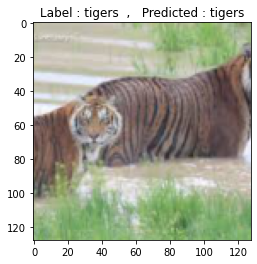

In [113]:
predict_image(*valid_ds[23])

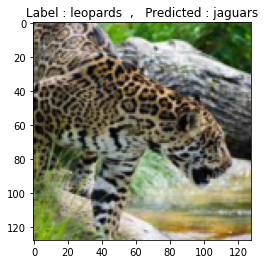

In [114]:
predict_image(*valid_ds[10])

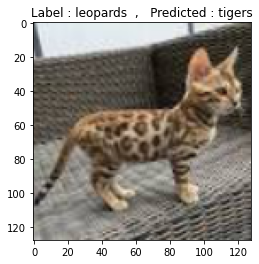

In [115]:
predict_image(*valid_ds[111])

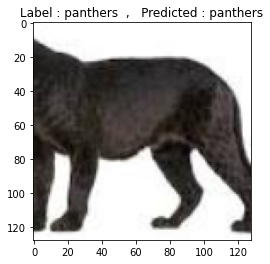

In [116]:
predict_image(*valid_ds[215])

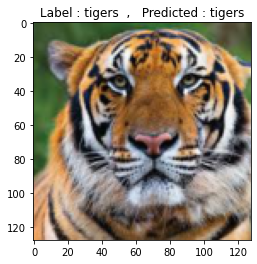

In [117]:
predict_image(*valid_ds[69])